[View in Colaboratory](https://colab.research.google.com/github/yala/MLCodeLab/blob/master/mnist_tutorial.ipynb)

# Introduction to Deep Learning Packages
In this tutorial, we'll take you through developing models to classify images in PyTorch from start to finish. We'll go through preprocessing, building neural networks, and experimentation.

Let's get started!

In [1]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision
import torch
print(torch.__version__)
print(torch.cuda.is_available())

0.4.0
True


In [0]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np


In [0]:
#@title Helper Function to display Images { display-mode: "form" }
def plot_images(images, cls_true):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(4,4))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(np.array(images[i], dtype='float').reshape((28,28))*255, cmap='binary')

        # Show true and predicted classes.

        xlabel = "True: {0}".format(cls_true[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## What is PyTorch
It's a python based deep learning library. It's very popular amongst researchers because of it's speed and flexibility. 

At the base of pytorch is the idea of a `Tensor`.
A `Tensor` is just an `n-dimensional` array, like a numpy `ndarray`.

For example,
Let's make a random `3x3` tensor.
We can inspect tensors by printing them, and get their size with `.size()` 

In [4]:
a = torch.rand(3,3)
print(a)
print(a.size())

tensor([[ 0.5238,  0.0974,  0.2254],
        [ 0.1550,  0.5569,  0.0857],
        [ 0.5265,  0.0187,  0.5555]])
torch.Size([3, 3])


We can also take an array, and convert it to a tensor.


In [5]:
b = torch.Tensor([[1,2,3],[4,5,6]])
print(b)
print(b.size())

tensor([[ 1.,  2.,  3.],
        [ 4.,  5.,  6.]])
torch.Size([2, 3])


### Operations on Tensors
Any operation between tensors produces new tensors.
You can use regular python syntax to add, multiply them. PyTorch also nice functions for matrix multipication, and reshaping tensors.


In [6]:
a = a + 4
print(a)
d = a * 2
print(d)
e = a - d
print(e)

print(a.size(), b.size())
# Wont work because shapes number of columns in a 
# doesn't match number of rows in b
'c = torch.matmul(a, b)'
# This will work
c = torch.matmul(b, a)
print(c.size())


tensor([[ 4.5238,  4.0974,  4.2254],
        [ 4.1550,  4.5569,  4.0857],
        [ 4.5265,  4.0187,  4.5555]])
tensor([[ 9.0475,  8.1948,  8.4508],
        [ 8.3099,  9.1138,  8.1714],
        [ 9.0530,  8.0374,  9.1110]])
tensor([[-4.5238, -4.0974, -4.2254],
        [-4.1550, -4.5569, -4.0857],
        [-4.5265, -4.0187, -4.5555]])
torch.Size([3, 3]) torch.Size([2, 3])
torch.Size([2, 3])


If you're running into a bug, it's often helpful to step through and check your dimensions.

### The magic: Autograd
The power behind PyTorch comes from its automatic differentiation engine, Autograd. To turn it on, construct your tensors with `requires_grad = True`.

Every computation you make, i.e `c=a+b` will create a computation graph with node `c` being linked to `a` and `b` via a `+` operator. 

<img src="https://raw.githubusercontent.com/yala/MLCodeLab/master/lab2/abc.png">

If you call `.backward()` on your final node, autograd will work out all the gradients for you and store the values in `a.grad` and `b.grad`.

Let's look at an example.

Consider the function
`y = a*(x^2) + b`, where `a = b = 1`. This is a simple parabola. 
<img src="https://raw.githubusercontent.com/yala/MLCodeLab/master/lab2/parabola.png">

The compute graph for this would be:
<img src="https://raw.githubusercontent.com/yala/MLCodeLab/master/lab2/parab_graph.png">

From basic calculas, we know that the derivative of `dy/dx` is
`dy/dx = 2a x`. So the derivative at `x = 1` is `2`. 
This wasn't very hard, but let's see how autograd can do this automatically.

In [7]:
a = torch.ones(1, requires_grad=False)
b = torch.ones(1, requires_grad=False)
x = torch.ones(1, requires_grad=True)
y = a*(x*x)  + b
print(y)
y.backward()
print("x.grad={}".format(x.grad))


tensor([ 2.])
x.grad=tensor([ 2.])


### Why autograd is exciting
Now, this may have seemed trivial and contrived, but this flexible automatic differentiation process really shines when our computation graph is large and complex, i.e when it's a neural network.

If we place our whole model into our computation graph, and the loss calculation, the a call to `backward`, will compute all the gradients, and it becomes very easy to train neural networks. 




# The Task: MNIST, Digit Classification
<img src="https://raw.githubusercontent.com/yala/MLCodeLab/master/lab2/mnist.png">

In this lab, we'll build a neural network to classify hand-written digits.



## Step 1: Loading Data and Preprocessing
Let's start by loading the data.
We're going to normalize our images to have 0 mean, and unit variance. We'll do this using some [torchvision](https://pytorch.org/docs/stable/torchvision/index.html) transforms. This generally helps stablize learning, and is common practice. 

In [0]:
# Img mean value of .13, and stdv of .31 were computed across entire train set
# in prior work
normalize_image = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                ])

# Dataset is loaded fro torchvision
all_train = datasets.MNIST('data', train=True, download=True, transform=normalize_image)

num_train = int(len(all_train)*.8)
train = [all_train[i] for i in range(num_train)]
dev = [all_train[i] for i in range(num_train,len(all_train))]
test = datasets.MNIST('data', train=False, download=True, 
                      transform=normalize_image)
                           


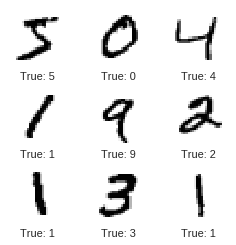

In [9]:
all_train = datasets.MNIST('data', train=True, download=True)
# images = [tr[0] for tr in all_train[:9]]
num_examples = 9 
images, labels = [], []
for i in range(num_examples):
  images.append(all_train[i][0])
  labels.append(all_train[i][1].item())
    
plot_images(images, labels)

In [10]:
train[0][0].size()

torch.Size([1, 28, 28])

## Step 2: Building a model

All pytorch models should be implemented as instances of `nn.Module`. 

To build a model you need to:
a) define what parameters it'll need in it's `__init__` function
b) define the model's computation, using those parameters, in a forward function.


To keep things simple, lets define a simple linear classifer, like logistic regression. We'll experiment with more complex models soon.

In [0]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Learn weights for each pixel and perform linear regression
        self.fc = nn.Linear(28*28, 10)

    def forward(self, x):
        batch_size, num_channels, height, width = x.size()
        # Flatten image
        x = x.view(batch_size, -1)
        # Put it through linear classifier
        return self.fc(x)


## Step 3. Defining our training procedure

To train our model, let's introduce a couple new PyTorch ideas.

A [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) is an iterator that goes over our entire dataset and selects batches. 
We'll be using this to iterate through our train/dev/test sets.

Let's intialize these now. 

An [Optimizer](https://pytorch.org/docs/stable/optim.html) defines an update rule. In class, we've discussed vanilla SGD, which is one method to compute the next weight, given the current weight and gradient. There are plently of other optimizers you can try from the pytorch library. 


In [0]:
# Training settings
batch_size = 64
epochs = 10
lr = .01
momentum = 0.5


train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dev, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)


model = Model()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)


To train our model:

1) we'll randomly sample batches from our train loader

2) compute our loss (using standard `cross_entropy`)

3) compute our gradients (by calling `backward()` on our loss)

4) update our neural network with an `optimizer.step()`, and go back to 1)

I've added some extra stuff here to log our accuracy and avg loss for the epoch.


In [0]:
def train_epoch( model, train_loader, optimizer, epoch):
    model.train() # Set the nn.Module to train mode. 
    total_loss = 0
    correct = 0
    num_samples = len(train_loader.dataset)
    for batch_idx, (x, target) in enumerate(train_loader): #1) get batch
        # Reset gradient data to 0
        optimizer.zero_grad()
        # Get prediction for batch
        output = model(x)
        # 2) Compute loss
        loss = F.cross_entropy(output, target)
        #3) Do backprop
        loss.backward()
        #4) Update model
        optimizer.step()
        
        ## Do book-keeping to track accuracy and avg loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        total_loss += loss.detach() # Don't keep computation graph 

    print('Train Epoch: {} \tLoss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            epoch, total_loss / num_samples, 
            correct, 
            num_samples,
            100. * correct / num_samples))


## Step 3.5 Define our evaluation loop
Similar to above, we'll also loop through our dev or test set, and compute our loss and accuracy. 
This lets us see how well our model is generalizing. 

In [0]:
def eval_epoch(model, test_loader, name):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = model(data)
        test_loss += F.cross_entropy(output, target).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name,
        test_loss, 
        correct, 
        len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


## Step 4: Training the model

In [15]:

for epoch in range(1, epochs + 1):
    train_epoch(model, train_loader, optimizer, epoch)
    eval_epoch(model,  dev_loader, "Dev")
    print("---")

Train Epoch: 1 	Loss: 0.0068, Accuracy: 42180/48000 (88%)

Dev set: Average loss: 0.0049, Accuracy: 10943/12000 (91%)

---
Train Epoch: 2 	Loss: 0.0050, Accuracy: 43579/48000 (91%)

Dev set: Average loss: 0.0046, Accuracy: 10999/12000 (92%)

---
Train Epoch: 3 	Loss: 0.0047, Accuracy: 43823/48000 (91%)

Dev set: Average loss: 0.0045, Accuracy: 11040/12000 (92%)

---
Train Epoch: 4 	Loss: 0.0046, Accuracy: 43994/48000 (92%)

Dev set: Average loss: 0.0044, Accuracy: 11037/12000 (92%)

---
Train Epoch: 5 	Loss: 0.0045, Accuracy: 44083/48000 (92%)

Dev set: Average loss: 0.0044, Accuracy: 11070/12000 (92%)

---
Train Epoch: 6 	Loss: 0.0044, Accuracy: 44220/48000 (92%)

Dev set: Average loss: 0.0043, Accuracy: 11090/12000 (92%)

---
Train Epoch: 7 	Loss: 0.0044, Accuracy: 44188/48000 (92%)

Dev set: Average loss: 0.0043, Accuracy: 11082/12000 (92%)

---
Train Epoch: 8 	Loss: 0.0043, Accuracy: 44257/48000 (92%)

Dev set: Average loss: 0.0043, Accuracy: 11095/12000 (92%)

---
Train Epoch: 9 	

# Step 5. Experiment with MLP
This model gets a dev accuracy of 93%, which isn't too bad. However, the power of neural networks comes from composing layers with nonlinearities.

Let's try a more complex model.

In [16]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)
        

    def forward(self, x):
        batch_size, num_channels, height, width = x.size()
        x = x.view(batch_size, -1)
        hidden = F.relu(self.fc1(x))
        hidden = F.relu(self.fc2(hidden))
        logit = self.fc3(hidden)
        return logit
    
model = Model()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train_epoch(model, train_loader, optimizer, epoch)
    eval_epoch(model,  dev_loader, "Dev")
    print("---")

Train Epoch: 1 	Loss: 0.0098, Accuracy: 40271/48000 (84%)

Dev set: Average loss: 0.0045, Accuracy: 10971/12000 (91%)

---
Train Epoch: 2 	Loss: 0.0040, Accuracy: 44405/48000 (93%)

Dev set: Average loss: 0.0033, Accuracy: 11265/12000 (94%)

---
Train Epoch: 3 	Loss: 0.0031, Accuracy: 45220/48000 (94%)

Dev set: Average loss: 0.0027, Accuracy: 11400/12000 (95%)

---
Train Epoch: 4 	Loss: 0.0025, Accuracy: 45758/48000 (95%)

Dev set: Average loss: 0.0023, Accuracy: 11499/12000 (96%)

---
Train Epoch: 5 	Loss: 0.0021, Accuracy: 46132/48000 (96%)

Dev set: Average loss: 0.0020, Accuracy: 11552/12000 (96%)

---
Train Epoch: 6 	Loss: 0.0018, Accuracy: 46397/48000 (97%)

Dev set: Average loss: 0.0019, Accuracy: 11579/12000 (96%)

---
Train Epoch: 7 	Loss: 0.0015, Accuracy: 46637/48000 (97%)

Dev set: Average loss: 0.0019, Accuracy: 11577/12000 (96%)

---
Train Epoch: 8 	Loss: 0.0014, Accuracy: 46818/48000 (98%)

Dev set: Average loss: 0.0017, Accuracy: 11611/12000 (97%)

---
Train Epoch: 9 	

## Step 6. Experiment with CNN
A 3 layer MLP gets a dev accuracy of 97%, a strong imporvement over the simple linear model.
Now let's experiment with a covolutional neural network.


In [17]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.hidden_dim = 32
        self.conv1 = nn.Conv2d(1, self.hidden_dim // 2, kernel_size=10)
        self.conv2 = nn.Conv2d(self.hidden_dim // 2, self.hidden_dim, kernel_size=10)
        self.fc = nn.Linear(self.hidden_dim, 10)
        
    def forward(self, x):
        batch_size, num_channels, height, width = x.size()
        
        hidden = F.relu(self.conv1(x))
        hidden = F.relu(self.conv2(hidden))
        hidden = hidden.view((batch_size, self.hidden_dim, -1))
        hidden,_ = torch.max(hidden, dim=-1)
        logit = self.fc(hidden)
        return logit
    
model = Model()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, epochs + 1):
    train_epoch(model, train_loader, optimizer, epoch)
    eval_epoch(model,  dev_loader, "Dev")
    print("---")

Train Epoch: 1 	Loss: 0.0054, Accuracy: 43366/48000 (90%)

Dev set: Average loss: 0.0017, Accuracy: 11625/12000 (97%)

---
Train Epoch: 2 	Loss: 0.0017, Accuracy: 46455/48000 (97%)

Dev set: Average loss: 0.0016, Accuracy: 11650/12000 (97%)

---
Train Epoch: 3 	Loss: 0.0013, Accuracy: 46828/48000 (98%)

Dev set: Average loss: 0.0011, Accuracy: 11762/12000 (98%)

---
Train Epoch: 4 	Loss: 0.0010, Accuracy: 47062/48000 (98%)

Dev set: Average loss: 0.0010, Accuracy: 11772/12000 (98%)

---
Train Epoch: 5 	Loss: 0.0008, Accuracy: 47223/48000 (98%)

Dev set: Average loss: 0.0008, Accuracy: 11812/12000 (98%)

---
Train Epoch: 6 	Loss: 0.0007, Accuracy: 47328/48000 (99%)

Dev set: Average loss: 0.0008, Accuracy: 11822/12000 (99%)

---
Train Epoch: 7 	Loss: 0.0006, Accuracy: 47394/48000 (99%)

Dev set: Average loss: 0.0008, Accuracy: 11817/12000 (98%)

---
Train Epoch: 8 	Loss: 0.0006, Accuracy: 47465/48000 (99%)

Dev set: Average loss: 0.0008, Accuracy: 11806/12000 (98%)

---
Train Epoch: 9 	

## Step 7. Explore further.
You can try different model architectures, different optimizers, learning rates and regularization strategies. Neural networks are incredibly flexibile, and so the space to do explore is enourmous.  Once you're done exploring, take your best model (i.e achieves best results on dev set) and run it on test!

In [18]:
eval_epoch(model,  test_loader, "Test")


Test set: Average loss: 0.0007, Accuracy: 9862/10000 (99%)



## Step 8. Now try it on your own on CIFAR
